In [1]:
# Author: Lee Yat Shun, Jasper
# Copyright (c) 2023 Lee Yat Shun, Jasper. All rights reserved.

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from caviar import CaviarModel

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('../data/SPY.xlsx')
df.columns = df.iloc[5].values
df = df.iloc[6:].iloc[::-1].reset_index(drop=True)
df['Log Return'] = df.PX_LAST.apply(lambda x: np.log(x)).diff()
df = df.set_index('Date')
df.head()

,PX_LAST,Change,% Change,PX_OPEN,Change,% Change,PX_HIGH,Change,% Change,PX_LOW,Change,% Change,Log Return
Date,,,,,,,,,,,,,
1993-01-29,25.2238,NaN,NaN,25.2417,NaN,NaN,25.2417,NaN,NaN,25.1161,NaN,NaN,NaN
1993-02-01,25.4032,NaN,NaN,25.2417,NaN,NaN,25.4032,NaN,NaN,25.2417,NaN,NaN,0.007087
1993-02-02,25.457,NaN,NaN,25.3852,NaN,NaN,25.4749,NaN,NaN,25.3314,NaN,NaN,0.002116
1993-02-03,25.7261,NaN,NaN,25.4929,NaN,NaN,25.744,NaN,NaN,25.4749,NaN,NaN,0.010515
1993-02-04,25.8337,NaN,NaN,25.8158,NaN,NaN,25.8876,NaN,NaN,25.762,NaN,NaN,0.004174


In [5]:
returns = df['Log Return'].dropna()

## Numeric

In [6]:
# initiate parameter
quantile = 0.05 # 1% VAR

In [7]:
# fitting process
caviar_model = CaviarModel(quantile, model='symmetric', method='numeric')
caviar_model.fit(returns[:-2000])

Generating 3 best initial betas out of 1000...
Optimizing by simplex method and quasi-newton method...
when m = 1
Update 0: 1.9877801174994272
Update 1: 0.12381699404723649
Update 2: 0.12381699378553085
Update 3: 0.12381699370037366
Final loss: 0.12381699370037366
Time taken(s): 0.76


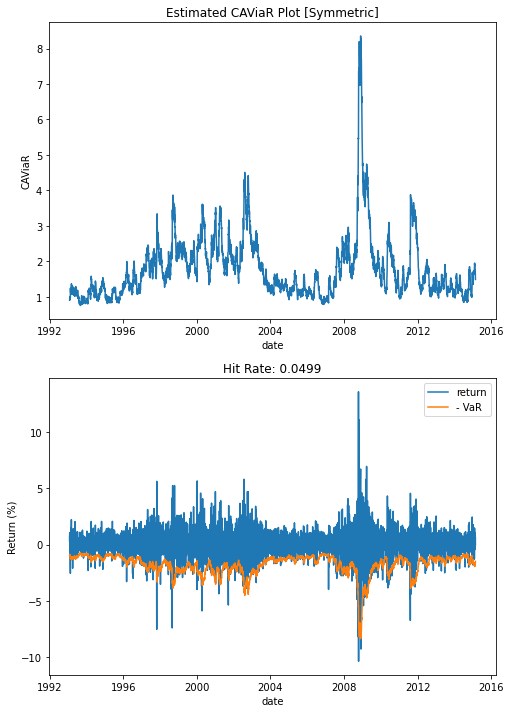

In [8]:
# in sample
caviar_model.plot_caviar(returns[:-2000])

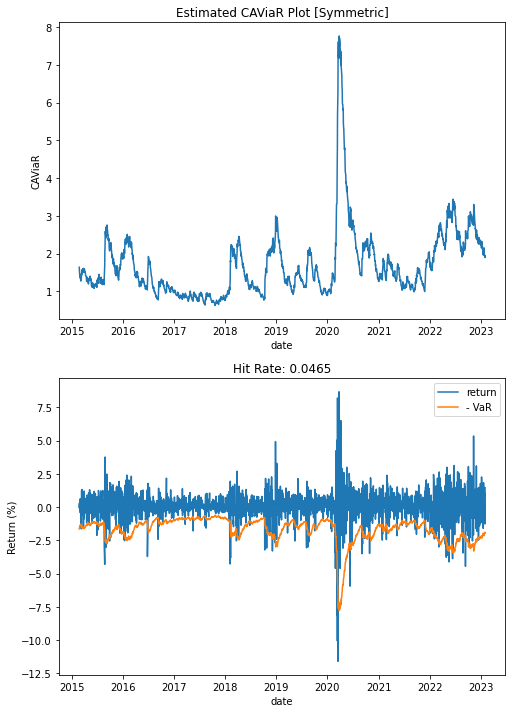

In [9]:
# out of sample
caviar_model.plot_caviar(returns[-2000:])

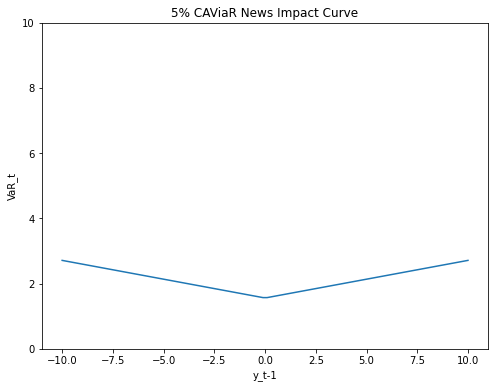

In [10]:
caviar_model.plot_news_impact_curve(VaR=-1.645)

In [11]:
# RQ loss
print(caviar_model.obj(caviar_model.beta, returns[:-2000], caviar_model.quantile, caviar_model.caviar))
print(caviar_model.obj(caviar_model.beta, returns[-2000:], caviar_model.quantile, caviar_model.caviar))

0.011705315565532929
0.011600730891386763


### VaR Test

In [28]:
from numpy.linalg import inv
from scipy.stats import norm

In [13]:
from caviar import dq_test, variance_covariance

In [14]:
beta = caviar_model.beta
model = caviar_model.model
T = len(returns)
quantile = caviar_model.quantile
VaR = caviar_model.predict(returns)

In [18]:
vc_matrix, D, gradient = variance_covariance(beta, model, T, returns, quantile, VaR)

In [31]:
beta_standard_errors = np.diag(vc_matrix) ** 0.5
beta_pvals = norm.cdf(-abs(beta) / standard_errors)